Since the tensorflow is super slow (3 times slower) with the eager mode, I change the code to subclassing API, tf.GradientTape(), tf.data.Datasets and @tf.function with graph mode to increase the speed.  
learn: https://zhuanlan.zhihu.com/p/70232196

# import

using fit_generatorto run the big data

testing for reading a series of files

In [2]:
import tensorflow as tf
print(tf.__version__)
print("is_gpu_available: ", tf.config.list_physical_devices('GPU'))
print(tf.config.list_physical_devices())

2.2.0
is_gpu_available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## import the lib

In [3]:
# impirt the lib
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import scipy.io
import os
from os import walk
from os.path import join

import sys
import random
from sklearn.model_selection import train_test_split

from scipy.io import loadmat
from os import listdir
from PIL import Image
import collections
from math import pi, sqrt, exp

import tensorflow.keras
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, Flatten, ActivityRegularization, BatchNormalization,GaussianNoise
from tensorflow.keras.regularizers import l1, l2

In [4]:
def gauss(n=6,sigma=1):
    r = range(-int(n/2),int(n/2)+1)
    return [1 / (sigma * sqrt(2*pi)) * exp(-float(x)**2/(2*sigma**2)) for x in r]

gaussfilter = gauss()

In [5]:
def ShowChaLoc(arraysize,channelID=[],xpos=[],ypos=[],show=True):
	if (channelID==[])& ((xpos==[]) or (ypos==[])):
		sys.exit('input channelID, or, xpos and ypos')
	if channelID != []:
		inlen = list(range(arraysize[0]*arraysize[1]))
		allindex = np.array(inlen)[channelID]
		xpos = np.int_(allindex / arraysize[0])
		ypos = np.int_(allindex % arraysize[1])
	if xpos.shape != ypos.shape:
		sys.exit('xpos and ypos have to be the same shape')
	if (max(xpos) > arraysize[0]) or (max(ypos) > arraysize[1]):
		sys.exit('xpos and ypos bigger than arraysize ???')
	imgbk=np.zeros(arraysize)
	for x,y in zip(xpos,ypos):
		imgbk[x,y]+=1
	if show == True:
		plt.imshow(imgbk)
		plt.show()
	else:
		return imgbk

In [6]:
def PlotTotalfiring(targetrate,CNNrate, init=30000,n_data = 1000):
	final = init+n_data
	fig, ax1 = plt.subplots()
	ax1.plot(np.sum(targetrate,axis=0)[init:final],'b',lw=2.5)
	ax1.set_xlabel('time (datapoint/10ms)', fontsize='16')
	ax1.set_ylabel('target', color='b', fontsize='16')
	ax1.tick_params('y',colors='b')
	ax2 = ax1.twinx()
	ax2.plot((np.sum(CNNrate,axis=0)[init:final]-min(np.sum(CNNrate,axis=0)[init:final])),'r')
	ax2.set_ylabel('CNN', color='r', fontsize='16')
	ax2.tick_params('y',colors='r')
	plt.show()

## CNN model

### Functional API

In [7]:
# def Tina_CNN(n_out,inshape = (49,49,40)):
#     inputs = Input(shape=inshape )
#     x = Conv2D(8, (15,15), kernel_regularizer=l2(0.01))(inputs) # (height, width)
#     x = BatchNormalization()(x)
#     x = GaussianNoise(0.05)(x)
#     x = Activation('relu')(x)
#     x = Conv2D(8, (11,11), kernel_regularizer=l2(0.01))(x)
#     x = BatchNormalization()(x)
#     x = GaussianNoise(0.05)(x)
#     x = Activation('relu')(x)
#     x = Flatten()(x)
#     x = Dense(n_out, use_bias=False)(x)
#     x = BatchNormalization()(x)
#     x = GaussianNoise(0.05)(x)
#     outputs = Activation('softplus')(x)
#     return Model(inputs, outputs, name='Tina_CNN')

### subclassing API

In [8]:
# class Tina_CNN(Model):
#     def __init__(self,n_out=60):
#         super(Tina_CNN, self).__init__()
#         self.conv1 = Conv2D(8, (15,15), kernel_regularizer=l2(0.01))
#         self.bn1 = BatchNormalization()
#         self.noise1 =  GaussianNoise(0.05)
#         self.activ1 = Activation('relu')
#         self.conv2 = Conv2D(8, (11,11), kernel_regularizer=l2(0.01))
#         self.bn2 = BatchNormalization()
#         self.noise2 =  GaussianNoise(0.05)
#         self.activ2 = Activation('relu')
#         self.flatten = Flatten()
#         self.dense = Dense(n_out, use_bias=False)
#         self.bn3 = BatchNormalization()
#         self.noise3 =  GaussianNoise(0.05)
#         self.activ3 = Activation('softplus')

#     def call(self, x, training=True):
#         x = self.conv1(x)
#         x = self.bn1(x,training=training)
#         x = self.noise1(x)
#         x = self.activ1(x)
#         x = self.conv2(x)
#         x = self.bn2(x,training=training)
#         x = self.noise2(x)
#         x = self.activ2(x)
#         x = self.flatten(x)
#         x = self.dense(x)
#         x = self.bn3(x,training=training)
#         x = self.noise3(x)
#         return self.activ3(x)



# def train_step(images, labels):
#     with tf.GradientTape() as tape:
#         # training=True is only needed if there are layers with different
#         # behavior during training versus inference (e.g. Dropout).
#         predictions = model(images, training=True)
#         loss = loss_object(labels, predictions)
#     gradients = tape.gradient(loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))

# # def train_CNN(dataset,train_step):
# #     for inputs, target in dataset:
# #         train_step(inputs, target)

# def test_step(images, labels):
#     # training=False is only needed if there are layers with different
#     # behavior during training versus inference (e.g. Dropout).
#     predictions = model(images, training=False)
#     t_loss = loss_object(labels, predictions)

# # def test_CNN(dataset,train_step):
# #     for inputs, target in dataset:
# #         train_step(inputs, target)    


## define batch reader generator

In [9]:
def LoadSpkAndImage(allspikes,imgfiles, batchsize, steps_per_epoch):
    
    trainimage = imgfiles[:steps_per_epoch*batchsize+40]

    trainspikes = allspikes[:steps_per_epoch*batchsize]

    if len(trainimage)-40 != trainspikes.shape[0]:
        import warnings
        warnings.warn('data size does not match', UserWarning)   
    return trainimage,trainspikes


In [10]:
def generate_arrays_from_file(allspikes,imgfiles, batchsize, steps_per_epoch):
    while 1:
#       print(spkfile,imgfolderpath)
        trainimage,trainspikes = LoadSpkAndImage(allspikes,imgfiles, batchsize, steps_per_epoch)
        loadcount = 0
        for dump in range(steps_per_epoch):
            # keep looping until we reach our batch size
            tempimgstack = [mpimg.imread(trainimage[i])/255.0 for i in range(loadcount,loadcount+batchsize+40)]
            imgstack = np.transpose([tempimgstack[j:-(40-j)] for j in range(40)],axes=[1,2,3,0])
            targetspikes = trainspikes[loadcount:loadcount+batchsize]
            loadcount += batchsize
            yield (imgstack, targetspikes)



# try_generator = generate_arrays_from_file(trainspk,trainimg, 100,10)
# testa,testb = next(try_generator)
# print(testa.dtype)
# print(testb.dtype)

In [11]:
# def generate_oneshot_array(allspikes,imgfiles, batchsize, steps_per_epoch):
#     while 1:
# #       print(spkfile,imgfolderpath)
#         trainimage,trainspikes = LoadSpkAndImage(allspikes,imgfiles, batchsize, steps_per_epoch)
#         loadcount = 0
#         for dump in range(steps_per_epoch):
#             tempimgstack = [mpimg.imread(trainimage[i])/255.0 for i in range(dump,dump+40)]
#             imgstack = np.transpose(tempimgstack,axes=[1,2,0])
#             targetspikes = trainspikes[dump]
#             loadcount += batchsize
#             yield (imgstack, targetspikes)


# # try_generator = generate_oneshot_array(trainspk,trainimg, 1,10)
# # testa,testb = next(try_generator)
# # testa.shape

In [12]:
# # def generate_oneshot_array(allspikes,imgfiles):
# def generate_oneshot_training():
#     for loadcount in range(len(imgfiles)-40):
#         trainimage = imgfiles[loadcount:loadcount+40]
#         trainspikes = allspikes[loadcount]
#         tempimgstack = [mpimg.imread(name)/255.0 for name in trainimage]
#         imgstack = np.transpose(tempimgstack,axes=[1,2,0])
#         targetspikes = trainspikes
#         yield imgstack, targetspikes

# # try_generator = generate_oneshot_array(trainspk,trainimg, 1,10)
# # testa,testb = next(try_generator)
# # testa.shape

# laod data

## Select channels: useful channel decided by the number of spikes

In [13]:
spkfolder = '/TinaData/ExpData/20200409Leo/'
spkfile = 'sort_merge_20200219saccade.mat'

file = spkfolder+spkfile
mat = scipy.io.loadmat(file)

In [14]:
print(file)
for fori in mat:
    print(fori)

/TinaData/ExpData/20200409Leo/sort_merge_20200219saccade.mat
__header__
__version__
__globals__
BinningInterval
TimeStamps
bin_pos
diode_BT
reconstruct_spikes
sorted_spikes


In [15]:
TimeStamps = mat.get('TimeStamps')[0]
spikes=mat.get('sorted_spikes')
BinningInterval = mat.get('BinningInterval')
bin_pos = mat.get('bin_pos')[0]
binningrate=[]
imgidx = []
bins = np.linspace(0, TimeStamps[1]-TimeStamps[0], num=bin_pos.shape[0]+1)
for i in range(60):
    out = np.histogram(spikes[0][i], bins=bins)
    dump = np.convolve(out[0],gaussfilter,mode='same')
    binningrate.append(dump[39:-1])
# imgidx.append(bin_pos[0])
    
print(len(bin_pos))
print(np.array(binningrate).shape)

ChTotalFiring = sum(np.array(binningrate).T).astype('int')
for loopcount,fori in enumerate(ChTotalFiring):
    print(loopcount+1,fori)

180057
(60, 180017)
1 3880
2 11614
3 9199
4 67935
5 29070
6 7272
7 10099
8 10093
9 19066
10 27445
11 11413
12 10433
13 10033
14 7559
15 5897
16 13233
17 22696
18 10134
19 9452
20 10324
21 2778
22 4733
23 14916
24 14034
25 9190
26 6843
27 9674
28 9359
29 4109
30 14920
31 0
32 2784
33 5922
34 737
35 656
36 640
37 233
38 13897
39 9381
40 6368
41 7743
42 10851
43 8942
44 8771
45 5392
46 14833
47 9990
48 7901
49 16053
50 9450
51 1538
52 8848
53 19618
54 2878
55 17811
56 16768
57 8875
58 10102
59 9686
60 17648


[ 1  2  3  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 22 23 24 25 26
 27 28 29 30 33 38 39 40 41 42 43 44 45 46 47 48 49 50 52 53 55 56 57 58
 59 60]
# channel= 50


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result e

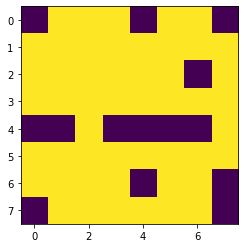

In [16]:
channelID = np.where((sum(np.array(binningrate).T)>3000)&(sum(np.array(binningrate).T)<36000))
print(channelID[0]+1)
print('# channel=',len(channelID[0]))
channelIDLoc = channelID[0].copy()
idx1 = [channelID[0]<6]
idx2 = [(6<=channelID[0])&(channelID[0]<54)]
idx3 = [54<=channelID[0]]
channelIDLoc[idx1]+=1
channelIDLoc[idx2]+=2
channelIDLoc[idx3]+=3

ShowChaLoc([8,8],channelID=channelIDLoc)

## load data

In [17]:
allspikes=np.array(binningrate)[channelID].T
print(allspikes.shape)


(180017, 50)


In [18]:
imgfilder = '/TinaData/CNNImage/20200223image/'
imgfilestemp = os.listdir(imgfilder)
imgfilestemp.sort()
imgfiles = []
for fori in bin_pos:
    imgfiles.append(imgfilder+imgfilestemp[fori-1])
print(len(imgfiles))

180057


In [19]:
if len(imgfiles)-40 != len(allspikes):
    import warnings
    warnings.warn('data size does not match', UserWarning)

# training a CNN

In [20]:
# %%script false 

# from package_Tina.PlotResult import PlotTotalfiring

# import importlib
# importlib.reload(PlotResult)

## training

In [21]:
aimg = mpimg.imread(imgfiles[0])
CNNW = aimg.shape[0]
CNNH = aimg.shape[1]

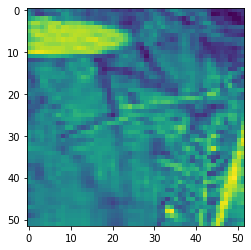

In [22]:
plt.imshow(aimg)
plt.show()

### define model

In [38]:
class Tina_CNN(Model):
    def __init__(self,n_out=60):
        super(Tina_CNN, self).__init__()
        self.conv1 = Conv2D(8, (15,15), kernel_regularizer=l2(0.01))
        self.bn1 = BatchNormalization()
        self.noise1 =  GaussianNoise(0.05)
        self.activ1 = Activation('relu')
        self.conv2 = Conv2D(8, (11,11), kernel_regularizer=l2(0.01))
        self.bn2 = BatchNormalization()
        self.noise2 =  GaussianNoise(0.05)
        self.activ2 = Activation('relu')
        self.flatten = Flatten()
        self.dense = Dense(n_out, use_bias=False)
        self.bn3 = BatchNormalization()
        self.noise3 =  GaussianNoise(0.05)
        self.activ3 = Activation('softplus')
        
    @tf.function
    def call(self, x, training=True):
        x = self.conv1(x)
        x = self.bn1(x,training=training)
        x = self.noise1(x)
        x = self.activ1(x)
        x = self.conv2(x)
        x = self.bn2(x,training=training)
        x = self.noise2(x)
        x = self.activ2(x)
        x = self.flatten(x)
        x = self.dense(x)
        x = self.bn3(x,training=training)
        x = self.noise3(x)
        return self.activ3(x)


In [39]:
n_out = len(channelID[0])
print('n_out=',n_out)
input_shape = (None,CNNW,CNNH,40)
print('input_shape=',input_shape)

model = Tina_CNN(n_out=n_out)
model.build(input_shape)
# model = Tina_CNN(n_out,inshape = (CNNW,CNNH,40)) #Functional API
model.summary()
# tf_model = tf.function(model)

n_out= 50
input_shape= (None, 52, 52, 40)
Model: "tina_cnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            multiple                  72008     
_________________________________________________________________
batch_normalization_3 (Batch multiple                  32        
_________________________________________________________________
gaussian_noise_3 (GaussianNo multiple                  0         
_________________________________________________________________
activation_3 (Activation)    multiple                  0         
_________________________________________________________________
conv2d_3 (Conv2D)            multiple                  7752      
_________________________________________________________________
batch_normalization_4 (Batch multiple                  32        
_________________________________________________________________
gaussian_noise

### create in/out data

In [29]:
splitratio = 0.8
N_epochs = 100
batchsize=1024

trainlen = int((len(allspikes)*splitratio//batchsize)*batchsize)
testlen =int(((len(allspikes)-trainlen)//batchsize)*batchsize)
print('trainlen=',trainlen,' testlen=',testlen)

trainspk = allspikes[:trainlen]
trainimg = imgfiles[:trainlen+40]
testspk = allspikes[trainlen:]
testimg = imgfiles[trainlen:]
print('trainspk=',len(trainspk),'trainimg=',len(trainimg),'testspk=',len(testspk),'testimg=',len(testimg))

steps_per_epoch = len(trainspk)//batchsize # num_samples // batch_size
Ntrain = batchsize*steps_per_epoch
print('batchsize=',batchsize, ', steps_per_epoch=',steps_per_epoch)

trainlen= 143360  testlen= 35840
trainspk= 143360 trainimg= 143400 testspk= 36657 testimg= 36697
batchsize= 1024 , steps_per_epoch= 140


In [30]:
# def generate_oneshot_array(allspikes,imgfiles):
def generate_oneshot_training():
    for loadcount in range(len(trainspk)):
        trainimage = trainimg[loadcount:loadcount+40]
        trainspikes = trainspk[loadcount]
        tempimgstack = [mpimg.imread(name)/255.0 for name in trainimage]
        imgstack = np.transpose(tempimgstack,axes=[1,2,0])
        targetspikes = trainspikes
        yield imgstack, targetspikes

def generate_oneshot_testing():
    for loadcount in range(len(testspk)):
        testimage = testimg[loadcount:loadcount+40]
        testspikes = testspk[loadcount]
        tempimgstack = [mpimg.imread(name)/255.0 for name in testimage]
        imgstack = np.transpose(tempimgstack,axes=[1,2,0])
        targetspikes = testpikes
        yield imgstack, targetspikes
# try_generator = generate_oneshot_array(trainspk,trainimg, 1,10)
# testa,testb = next(try_generator)
# testa.shape

In [ ]:
train_generator = generate_oneshot_training()
images, labels = next(train_generator)

print(images.dtype, images.shape)
print(labels.dtype, labels.shape)

In [ ]:
# for i in range(150):
#     print(i)
#     images, labels = next(train_generator)
#     plt.imshow(images[:,:,0])
#     plt.show()
#     print(labels[:10])
#     print(images[:10,0,0])

In [31]:
train_ds = tf.data.Dataset.from_generator(generate_oneshot_training,
                                          output_types=(tf.float64, tf.float64),
                                          output_shapes=(tf.TensorShape([52, 52, 40]), tf.TensorShape([50])
                                          ))

In [32]:
train_data = train_ds.batch(1024).take(140)

In [ ]:
for x,y in train_data: print(np.array(x).shape,np.array(y).shape)

### training

In [33]:
# loss_object = tf.keras.losses.Poisson()
loss_object = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(0.01)
train_loss = tf.keras.metrics.Mean(name='train_loss')

In [34]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        # training=True is only needed if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    
    train_loss(loss)


# tf_train_step = tf.function(train_step)

# def train_CNN(dataset,train_step):
#     for inputs, target in dataset:
#         train_step(inputs, target)

@tf.function
def test_step(images, labels):
    # training=False is only needed if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    predictions = model(images, training=False)
    t_loss = loss_object(labels, predictions)


# tf_test_step = tf.function(test_step)

# def test_CNN(dataset,train_step):
#     for inputs, target in dataset:
#         train_step(inputs, target)    


In [37]:
import time
N_epochs = 1
for epoch in range(N_epochs):
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()
    start_time = time.time()
    for images, labels in train_data:
        train_step(images, labels)
    end_time = time.time()
    print("total time taken this loop: ", end_time - start_time)
    template = 'Epoch {}, Loss: {}'
    print(template.format(epoch + 1, train_loss.result()))

total time taken this loop:  2368.6875863075256
Epoch 1, Loss: 0.06839263439178467


## save the trained model

In [ ]:
# %%script false 
model.save('David20200418_CNN20200223_a1.h5')

## train more ...

In [ ]:
adam_tune=keras.optimizers.Adam(lr=0.0005)
model.compile(loss='poisson', optimizer=adam_tune)
model.fit_generator(generate_arrays_from_file(trainspk,trainimg, batchsize, steps_per_epoch),steps_per_epoch=steps_per_epoch, epochs=N_epochs*2)

In [ ]:
model.save('David20200418_CNN20200223_a2.h5')

In [ ]:
adam_tune=keras.optimizers.Adam(lr=0.0001)
model.compile(loss='poisson', optimizer=adam_tune)
model.fit_generator(generate_arrays_from_file(trainspk,trainimg, batchsize, steps_per_epoch),steps_per_epoch=steps_per_epoch, epochs=N_epochs*2)

In [ ]:
model.save('David20200418_CNN20200223_a3.h5')

# study the CNN

## load a trained model

In [ ]:
n_out = allspikes.shape[1]
aimg = mpimg.imread(imgfiles[0])
CNNW = aimg.shape[0]
CNNH = aimg.shape[1]
def Tina_CNN(n_out):
    inputs = Input(shape=(CNNW,CNNH,40))
    x = Conv2D(8, (15,15), kernel_regularizer=l2(0.01))(inputs) # (height, width)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.05)(x)
    x = Activation('relu')(x)
    x = Conv2D(8, (11,11), kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.05)(x)
    x = Activation('relu')(x)
    x = Flatten()(x)
    x = Dense(n_out, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = GaussianNoise(0.05)(x)
    outputs = Activation('softplus')(x)
    return Model(inputs, outputs, name='Tina_CNN')

model = Tina_CNN(n_out)
model.load_weights('/home/tina/disk/TensorflowCodeTina/CoremTest/David20200418_CNN20200223_a3.h5')

In [ ]:
def generate_ImgSpkData(spkfile,trainimage):
    tempimgstack = [mpimg.imread(i)/255.0 for i in trainimage]
    imgstack = np.transpose([tempimgstack[j:-(40-j)] for j in range(40)],axes=[1,2,3,0])
    targetspikes = spkfile
    return imgstack, targetspikes



In [ ]:
print(allspikes.shape,len(imgfiles))

In [ ]:
startidx = 3000
usedlen = 30000
spkused = allspikes[startidx:startidx+usedlen]
imgused = imgfiles[startidx:startidx+usedlen+40]
imgstack, targetspikes = generate_ImgSpkData(spkused,imgused)


In [ ]:
# %%script false 
pred = model.predict(imgstack, verbose=1)

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(sum(targetspikes.T))
plt.plot(sum(pred.T))
plt.xlim([0,1000])
plt.show()

In [ ]:
sig = sum(targetspikes.T)
from scipy import signal
corr = signal.correlate(sig, sig, mode='same')
plt.plot(corr)
plt.xlim([1000,1200])
plt.show()

## kernals of the CNN

In [ ]:
def get_layer_output(model, model_inputs, outputlayer=3, training_flag=False, plot_flag=False, batchnum=0, kernelnum=0):
    from keras import backend as K
    get_output = K.function([model.layers[0].input, K.learning_phase()],[model.layers[outputlayer].output])
    layer_output = get_output([model_inputs, training_flag])[0]
    if plot_flag:
        plt.imshow(outs[batchnum,:,:,kernelnum])
        plt.show()
    return layer_output
# outputs = [layer.output for layer in model.layers]          # all layer outputs
# functors = [K.function([inp]+ [K.learning_phase()], [out]) for out in outputs] # evaluation functions

def get_kernel(model, layerID=0, channelID=0, kernelID=0):
    modelconfig=model.get_config()
    modelweight=model.get_weights()
    tempkernel = np.squeeze(modelweight[layerID][:,:,channelID,kernelID])
    return tempkernel

In [ ]:
# %%script false 

layerID = 0
Nchannel = model.get_weights()[layerID].shape[2]
Nkernel = model.get_weights()[layerID].shape[3]
for j in range(Nkernel):
    for i in range(Nchannel):
        print("NKernel", j)
        print("Nchannel", i)
        plt.imshow(get_kernel(model, layerID=layerID, channelID=i, kernelID=j))
        plt.colorbar()
        plt.show()

## receptive field (RF) of the COREM and CNN

In [ ]:
def ReceptiveField3D(FiringRate, npfolderpath=None, imgstack=None):
	RFallimage = np.zeros((FiringRate.shape[0],40,CNNW,CNNH))
	channelID = 0
	if (imgstack is None) and (npfolderpath is None):
		print("input npfolderpath or imgstack")
		npfolderpath=input("npfolderpath=")
	if npfolderpath is not None:
		print("npfolderpath")
		files = listdir(npfolderpath)
		files.sort()
		for j in FiringRate:
			spikeind = np.nonzero((j>np.std(j))*1)[0]+39
			for i in spikeind:
				for k in range(40):
					RFallimage[channelID,39-k,:,:] += np.load(npfolderpath+files[i-k])
			RFallimage[channelID,:,:,:] = RFallimage[channelID,:,:,:]/len(spikeind)
			channelID += 1   
	else:
		print("imgstack")
		imgstack = np.transpose(imgstack,axes=[0,3,1,2])
		for j in FiringRate:
			spikeind = np.nonzero((j>np.std(j))*1)[0]
			for i in spikeind:
				RFallimage[channelID,:,:,:] += imgstack[i]
			RFallimage[channelID,:,:,:] = RFallimage[channelID,:,:,:]/len(spikeind)
			channelID += 1
	return RFallimage

In [ ]:
imgstack.shape
targetspikes.shape

In [ ]:
RFCOREM3D = ReceptiveField3D(targetspikes.T,imgstack=imgstack)
RFCNN3D = ReceptiveField3D(pred.T,imgstack=imgstack)
for i,j,k in zip(RFCOREM3D,RFCNN3D,channelIDLoc):
    plt.subplot(1, 3, 1)
    plt.imshow(i[-1,:,:])
    plt.subplot(1, 3, 2)
    plt.imshow(j[-1,:,:])
    plt.subplot(1, 3, 3)
    plt.imshow(ShowChaLoc([8,8],channelID=[k],show=False))
    plt.show()

# apply the stimuli

## on off stimulus

In [ ]:
def onoffsti(data,savepng = False, outputpath='/home/hydrolab/Desktop/COREM-Tina/COREM/input_sequences'):
    if savepng == False:        
        imgback = np.zeros((len(data),CNNW,CNNH))
        for i in range(len(data)) :
            idex = [data[i]]*CNNW*CNNH
            checker = np.reshape(idex,(CNNW,CNNH))
            imgback[i,:,:]= checker
        return imgback
    if savepng == True:
        os.chdir(outputpath)
        expday = datetime.datetime.now().strftime("%Y_%m_%d")
        if not os.path.exists(expday+'_onoffimg'):
            os.makedirs(expday+'_onoffimg')
        outimgpath = os.getcwd()+'/'+expday+'_onoffimg'
        for count in range(len(data)) :
            idex = [data[count]*255]*2401
            checker = np.reshape(idex,(CNNW,CNNH)).astype('uint8')
            imgname = outimgpath+'/stimulus_'+'%05d' % count+'.png'
            im = Image.fromarray(checker)
            im.save(imgname)
        print('finish save onoff sti', imgname)

In [ ]:
onoffbase = ([[1]*50+[0]*50]*10)
onoffdata = [item for sublist in onoffbase for item in sublist]
onoffimg = onoffsti(onoffdata)
onoffimgstack = np.transpose([onoffimg[i:-(40-i)] for i in range(40)],axes=[1,2,3,0])

In [ ]:
onoffpred = model.predict(onoffimgstack)
onofftotalint = np.sum((np.sum(onoffimg,axis=1)),axis=1)[39:-1]

In [ ]:
from package_Tina.PlotResult import plotyy_Tina

In [ ]:
plotyy_Tina(onofftotalint,sum(onoffpred.T),xrange=[0,1000],label=['sti','CNN'])

In [ ]:
for i in onoffpred.T:
    plotyy_Tina(onofftotalint,i,xrange=[200,400],label=['sti','CNN'])

## bar stimulus

In [ ]:
def reversedbar(x=[],savepng=False, outputpath='/home/hydrolab/Desktop/COREM-Tina/COREM/input_sequences'):
	if x ==[]:
		x = (list(range(CNNW))+list(range(CNNH))[::-1])*60
	if savepng==False:
		imgback = np.zeros((len(x),CNNW,CNNH))
		for i,pos in enumerate(x) :
			imgback[i,pos,:]=1
		return x, imgback
	if savepng==True:
		os.chdir(outputpath)
		expday = datetime.datetime.now().strftime("%Y_%m_%d")
		if not os.path.exists(expday+'_barimg'):
		    os.makedirs(expday+'_barimg')
		outimgpath = os.getcwd()+'/'+expday+'_barimg'
		for count, pos in enumerate(x) :
			imgback = np.zeros((CNNW,CNNH))
			imgback[pos,:]=255
			checker = imgback.astype('uint8')
			imgname = outimgpath+'/stimulus_'+'%05d' % count+'.png'
			im = Image.fromarray(checker)
			im.save(imgname)
		print('finish save checker', imgname)

In [ ]:
x, barimg = reversedbar()

In [ ]:
barimgstack = np.transpose([np.array(barimg)[i:-(40-i)] for i in range(40)],axes=[1,2,3,0])

In [ ]:
barpred = model.predict(barimgstack)
bartotalint = np.sum((np.sum(barimg,axis=1)),axis=1)[39:-1]

In [ ]:
plotyy_Tina(np.array(x[39:-1]),sum(barpred.T),xrange=[0,500],label=['sti','CNN'])

In [ ]:
for count,i in enumerate(barpred.T):
    plt.imshow(ShowChaLoc([8,8],channelID=[channelIDLoc[count]],show=False))
    plt.show()
    plotyy_Tina(np.array(x[39:-1]),i,xrange=[0,1000],label=['sti','CNN'])

## HMM whole field

In [ ]:
from random import gauss

def HMM(Delta = 0.1, Gamma = 0.2, sDD = 0.01,dt=0.01):
    # Generate HMM time series
    omega2 = (Gamma/(2*1.06))**2
    xs = []
    vs = []
    x = 0
    v = 0
    tt = [] # time index
    for i in range(20000):
        tt.append(i)
        tp = x
        x = x+v*dt
        v = (1-Gamma*dt)*v-omega2*tp*dt+gauss(0,sDD)*(Delta*dt)**0.5
        xs.append(x)
        vs.append(v)
    return xs,vs

def OU(Delta = 0.1,Gamma = 5.0,sDD = 0.1,dt=0.01):
    xs = []
    x = 0 
    for i in range(10000):
        tp = x
        x = (1-dt*Gamma/(2.12)**2)*x+gauss(0,sDD)*(Delta*dt)**0.5
        xs.append(x)
    return xs

In [ ]:
HMMxs,_ = HMM()
plt.plot(xs)
plt.show()

In [ ]:
HMMonoffimg = onoffsti(HMMxs)
HMMonoffimgstack = np.transpose([HMMonoffimg[i:-(40-i)] for i in range(40)],axes=[1,2,3,0])
HMMonoffpred = model.predict(HMMonoffimgstack)
HMMonofftotalint = np.sum((np.sum(HMMonoffimg,axis=1)),axis=1)[39:-1]
plotyy_Tina(HMMonofftotalint,sum(HMMonoffpred.T),xrange=[0,1000],label=['sti','CNN'])